In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [2]:
#Подгружаем данные
customers = pd.read_csv('olist_customers_dataset.csv')

In [3]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [4]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [5]:
# Переводим колонки датафрейма orders, где есть дата в тип даты
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [6]:
# Переводим колонку shipping_limit_date датафрейма order_items, где есть дата в тип даты
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

Общие данные по датафрейму customers:

1. customer_id - уникальных пользователей 99441;
2. Дубликаты/пустые значения отсутствуют по всему датафрейму;

Общие данные по датафрейму orders:

1. Дубликаты отсутствуют. Пустые значения есть в столбцах, отвечающих за:
   - время подтверждения оплаты заказа (160);
   - время передачи заказа в логистическую службу (1783);
   - время доставки заказа (2965).
2. Доставленных заказов (статус delivered) - 96478;
   Cозданных заказов (статус created) - 5;
   Подтвержденных заказов (статус approved) - 2;
   Выставлен счет (статус invoiced) - 314;
   В процессе сборки заказа (статус processing) - 301;
   Отгружен со склада (статус shipped) - 1107;
   Заказ отменён по причине недоступности товара (статус unavailable) - 609;
   Заказ отменен - 625. 
3. Значения по времени создания заказа(order_purchase_timestamp) и времени подтверждения оплаты заказа(order_approved_at):
   - mean: 10 ч. 25 минут;
   - std: 1 день 2 ч.;
   - min: сразу же происходит оплата;
   - max: через 187 дней;
   - медиана: 20 минут.
4. Значения по времени передачи заказа в логистическую службу(order_delivered_carrier_date) и времени подтверждения оплаты заказа(order_approved_at):
   - mean: 2 дн, 19ч. 19 минут;
   - std: 3 дня, 13 ч. 11 минут;
   - max: через 125 дней;
   - медиана: 1 день, 19 ч, 38 минут.
5. Значения по времени доставки заказа(order_delivered_customer_date) и времени передачи заказа в логистическую службу (order_delivered_carrier_date):
   - mean: 9 дн, 7 ч. 55 минут;
   - std: 8 дн, 18 ч. 14 минут;
   - max: через 205 дней;
   - медиана: 7 дн, 2 ч, 23 минут.
   
6. В среднем обещанное время доставки (order_estimated_delivery_date) и фактические время доставки (order_delivered_customer_date) превышает 11 дней. То есть, заказы доставляются раньше обещанных сроков. 


Общие данные по датафрейму orders_items:

1. Дубликаты отсутствуют. Пустые значения есть в столбцах, отвечающих за:
   - время подтверждения оплаты заказа (160);
   - время передачи заказа в логистическую службу (1783);
   - время доставки заказа (2965).
   
2. Значения по столбцу order_item_id:
   - максимальное количество товаров в одном заказе - 21;
   - минимальное количество товаров в одном заказе - 1;
   - среднее количество товаров в одном заказе - 1.
   
3. Самый популярный товар (product_id) - aca2eb7d00ea1a7b8ebd4e68314663af;
   Кол-во уникальных купленных товаров - 32951;
   Самый популярный товар купили 527 раз.

4. В среднем дата доставки продавцом для передачи заказа партнеру по логистике (shipping_limit_date) и время передачи заказа в логистическую службу(order_delivered_customer_date) занимает 3 дня и 8 часов.

5. По значениям столбца price:

   - mean: 120.65;
   - std: 183.63;
   - min: 0.85;
   - max: 6735.00;
   - медиана: 74.99.
   
   

In [7]:
# Рассчитываем разность даты, приехал ли заказ с опозданием или нет
orders['deliver_date_difference_estimated'] = orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']

In [8]:
# Соединяем датафрейм customers и orders в датафрейм df_2
df_2 = pd.merge(customers, orders, on='customer_id', how='inner')

In [9]:
# Соединяем датафрейм df_2 и датафрейм order_items
df_3 = pd.merge(df_2, order_items, on='order_id', how='inner')

In [10]:
# Рассчитываем разность, когда заказ передали в логистическую компанию
df_3['shipping_limit_date_logistics'] = df_3['shipping_limit_date'] - df_3['order_delivered_carrier_date']

In [11]:
# Переводим датафрейм в дату
df_3['shipping_limit_date'] = pd.to_datetime(df_3['shipping_limit_date'])

Задание №1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

In [15]:
# Предполагается, что df_3 уже загружен и содержит нужные данные
cohort_orders_2 = df_3[['customer_unique_id', 'order_purchase_timestamp', 'order_status']]
cohort_orders_2 = cohort_orders_2.query('order_status == "delivered"')

# Извлекаем месяц и день заказа
cohort_orders_2['order_period'] = cohort_orders_2['order_purchase_timestamp'].dt.to_period('M')
cohort_orders_2['order_period_day'] = cohort_orders_2['order_purchase_timestamp'].dt.to_period('D')

# Присваиваем когорты на основе даты первого действия для каждого пользователя
cohort_orders_2['cohort'] = cohort_orders_2.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
cohort_orders_2['cohort_day'] = cohort_orders_2.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

# Рассчитываем номер периода в днях
# Преобразуем периоды в временные метки
cohort_orders_2['period_number_month'] = (
    (cohort_orders_2['order_period_day'].dt.to_timestamp() - cohort_orders_2['cohort_day'].dt.to_timestamp()).dt.days // 30
)

# Проверка результата
print(cohort_orders_2[['customer_unique_id', 'order_period_day', 'cohort_day', 'period_number_month']])



                      customer_unique_id order_period_day  cohort_day  \
0       861eff4711a542e4b93843c6dd7febb0       2017-05-16  2017-05-16   
1       290c77bc529b7ac935b93aa66c333dc3       2018-01-12  2018-01-12   
2       060e732b5b29e8181a18229c7b0b2b5e       2018-05-19  2018-05-19   
3       259dac757896d24d7702b9acbbff3f3c       2018-03-13  2018-03-13   
4       345ecd01c38d18a9036ed96c73b8d066       2018-07-29  2018-07-29   
...                                  ...              ...         ...   
112645  1a29b476fee25c95fbafc67c5ac95cf8       2018-04-07  2018-04-07   
112646  d52a67c98be1cf6a5c84435bd38d095d       2018-04-04  2018-04-04   
112647  e9f50caf99f032f0bf3c55141f019d99       2018-04-08  2018-04-08   
112648  73c2643a0a458b49f58cea58833b192e       2017-11-03  2017-11-03   
112649  84732c5050c01db9b23e19ba39899398       2017-12-19  2017-12-19   

        period_number_month  
0                         0  
1                         0  
2                         0  
3  

In [16]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = cohort_orders_2.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [17]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [18]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [19]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

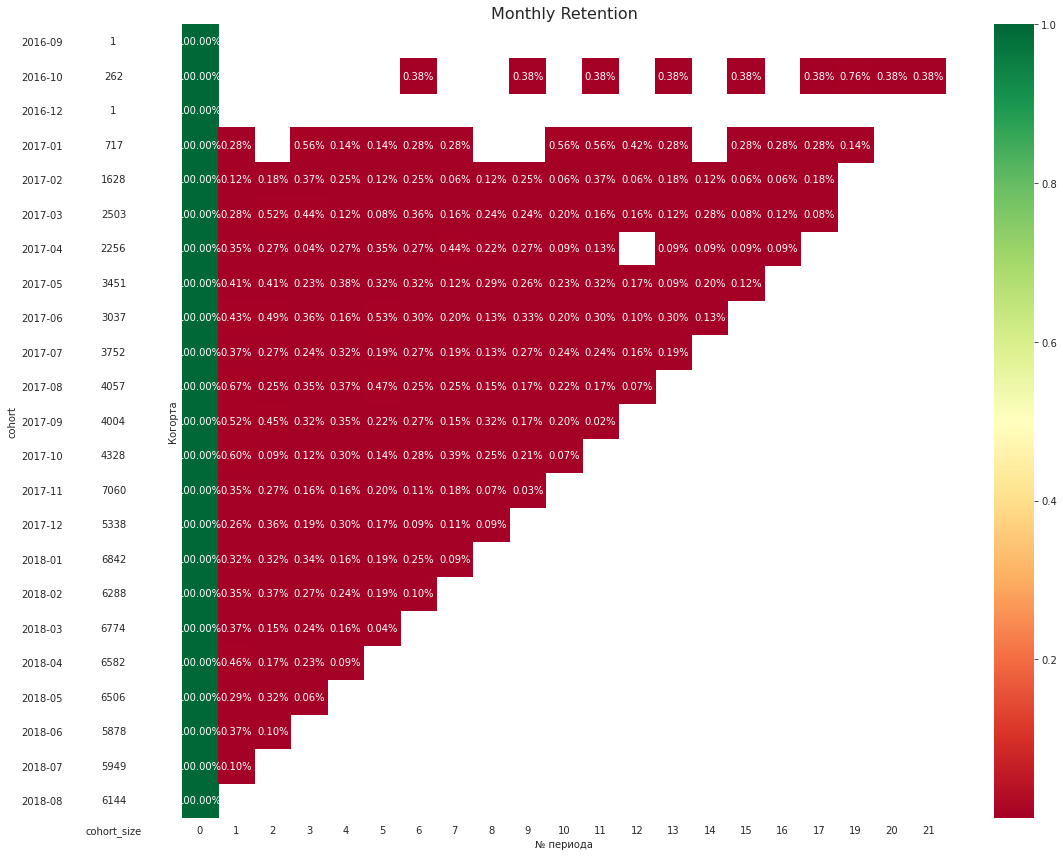

In [20]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.2%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [21]:
# Фильтруем данные для первого месяца (period_number_month == 0)
retention_first_month = cohort_orders_2[cohort_orders_2['period_number_month'] == 1]

In [22]:
# Группируем данные по когорте и считаем количество уникальных пользователей
cohort_sizes = cohort_orders_2.groupby('cohort')['customer_unique_id'].nunique().reset_index(name='cohort_size')
retention_first_month_counts = retention_first_month.groupby('cohort')['customer_unique_id'].nunique().reset_index(name='retention_count')

In [23]:
# Объединяем данные о размерах когорт и количестве повторных заказов
retention_first_month_data = pd.merge(cohort_sizes, retention_first_month_counts, on='cohort', how='left')

In [24]:
# Рассчитываем retention для первого месяца
retention_first_month_data['retention_first_month'] = retention_first_month_data['retention_count'] / retention_first_month_data['cohort_size']

In [25]:
# Посчитываем медиану retention для первого месяца
median_retention_first_month = retention_first_month_data['retention_first_month'].median()

In [26]:
median_retention_first_month

0.0035460992907801418

Когорта с самым высоким retention на 3-й месяц - это январь 2017 года, там 0.56% возвращения пользователей. 

Задача 2. Определить, существует ли product/market fit у маркетплейса.

In [27]:
# Посчитаем медианный retention 5 месяца, чтобы примерно понять, остаются ли клиенты в нашем маркетплейсе.
# Повторим тот же код, что с расчетом медианы для первого месяца.

retention_five_month = cohort_orders_2[cohort_orders_2['period_number_month'] >= 5]
cohort_sizes_5 = cohort_orders_2.groupby('cohort')['customer_unique_id'].nunique().reset_index(name='cohort_size')
retention_five_month_counts = retention_five_month.groupby('cohort')['customer_unique_id'].nunique().reset_index(name='retention_count')
retention_five_month_data = pd.merge(cohort_sizes, retention_five_month_counts, on='cohort', how='left')
retention_five_month_data['retention_five_month'] = retention_five_month_data['retention_count'] / retention_five_month_data['cohort_size']
median_retention_five_month = retention_five_month_data['retention_five_month'].median()

Медиана Retention на пятый месяц будет составлять 0.0168, что говорит о снижении Retention. Линейный график внизу подтверждает, что Retention падает.

На основе этих данных, плюс учитывая продукт, с которым мы работаем - маркетплейс, предполагающий частое возвращение клиента в продукт для совершения покупок, можно сделать вывод, что PMF в данном случае отсутствует. 

Причин отсутствия PMF могут быть несколько:
1. Одна из главных причин - это проблемы маркетплейса с доставкой, так как 8714 товаров были доставлены с задержкой (внизу будет расчет этой величины);
2. 609 заказов отменены из-за отсутствия товаров на складе - проблема с обновлением данных? Еще 625 заказов отменены пользователями. Соответственно, есть событие, которое заставляет пользователей отменить заказ. Либо это личное желание пользователя - отменить заказ. Нужно более детальное рассмотрение.

На данный момент, с низким retention и следствие - отсутствием PMF, начинать масштабирование - плохая идея. Плохая в том плане, что может возникнуть эффект "дярявого ведра", так как проблемы с доставкой и отменой заказов не будут решены и люди не будут задерживаться в продукте. Соответственно, когда эти проблемы будут решены, тогда можно после анализа эффективности каналов, говорить о масштабировании продукта. 

Как вариант, можно использовать такие каналы привлечения, как:
- социальные сети;
- SEO (система поиска);
- обновить систему отзывов.

In [28]:
# Фильтруем столбцы, которые необходимы для поиска товаров с задержкой
df_4 = df_3[['customer_unique_id', 'order_status', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'deliver_date_difference_estimated']]

In [29]:
# Выбираем только те значения в столбце deliver_date_difference_estimated, когда разница дней была отрицательной.
negative_diffs = df_4[df_4['deliver_date_difference_estimated'] < pd.Timedelta(0)]

In [66]:
# Фильтруем те заказы, которые были только доставлены
negative_diffs_delivered = negative_diffs.query('order_status == "delivered"')

In [67]:
negative_diffs_delivered

,customer_unique_id,order_status,order_delivered_carrier_date,order_estimated_delivery_date,deliver_date_difference_estimated
2,060e732b5b29e8181a18229c7b0b2b5e,delivered,2018-06-11 14:31:00,2018-06-13,-2 days +06:01:09
18,7f3a72e8f988c6e735ba118d54f47458,delivered,2017-05-15 15:30:02,2017-05-30,-9 days +11:57:46
35,e079b18794454de9d2be5c12b4392294,delivered,2017-06-22 08:11:38,2017-07-07,-1 days +03:27:13
36,e079b18794454de9d2be5c12b4392294,delivered,2017-06-22 08:11:38,2017-07-07,-1 days +03:27:13
67,c80da60feddb7cf8325bd104032e314a,delivered,2018-04-12 23:36:29,2018-04-23,-16 days +07:07:53
...,...,...,...,...,...
112624,522e244a96d13876c5bac4985a8d5075,delivered,2018-02-16 16:28:33,2018-03-13,-4 days +03:56:07
112625,522e244a96d13876c5bac4985a8d5075,delivered,2018-02-16 16:28:33,2018-03-13,-4 days +03:56:07
112634,15637b62dfa4c5a9df846b22beef0994,delivered,2018-02-14 20:22:56,2018-03-15,-15 days +03:33:18
112638,82d46759af0369aad49084bacf85a6c3,delivered,2017-11-27 20:44:47,2017-12-12,-8 days +04:22:27


Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Из условий задачи следует:

- Первая метрика должна отражать рост объёма продаж маркетплейса.
На мой взгляд, здесь может подойти метрика объема продаж. Метрика должна показывать какой объем продаж у маркетплейса и сколько пользователи тратят средств на покупки. 

Объем продаж (Revenue) = SUM(стоимость товаров * кол-во товаров в заказе)

Учитывая, что заказы могут быть отменены или могут возникнуть проблемы с доставкой, буду рассчитывать метрику с учетом доставленных товаров в июне 2017 года.

In [31]:
# Выбираем нужные нам столбцы
df_revenue_metrics = df_3[['customer_unique_id', 'order_status', 'order_delivered_customer_date', 'price', 'order_item_id']]

In [32]:
# Фильтруем данные, чтобы был только июнь месяц и доставленные заказы
df_metrics_query = df_revenue_metrics.query('order_delivered_customer_date >= "2017-06-01" and order_delivered_customer_date <= "2017-06-30"')

In [33]:
df_metrics_query_delivered = df_metrics_query.query('order_status == "delivered"')

In [34]:
# Считаем прибыль
df_metrics_query_delivered['revenue'] = df_metrics_query_delivered['price'] * df_metrics_query_delivered['order_item_id']

In [71]:
df_metrics_query_delivered

,customer_unique_id,order_status,order_delivered_customer_date,price,order_item_id,revenue
18,7f3a72e8f988c6e735ba118d54f47458,delivered,2017-06-07 12:02:14,89.90,1,89.90
57,d85547cd859833520b311b4458a14c1c,delivered,2017-06-19 19:32:32,788.42,1,788.42
91,fd2d5fdb84e65fa6b54b98b0e2df5645,delivered,2017-06-02 13:06:02,44.90,1,44.90
122,8728c766c84eeda24b3e54fe6e632051,delivered,2017-06-19 20:09:36,117.30,1,117.30
158,bb50112c998293f45f49f49704165768,delivered,2017-06-02 15:54:50,18.90,1,18.90
...,...,...,...,...,...,...
112337,9bab4772c790be2269300fe0d3a0ed69,delivered,2017-06-02 15:08:57,79.70,1,79.70
112540,f60fe3cb5de099b3055c4cefada6c1c7,delivered,2017-06-26 10:03:43,22.00,1,22.00
112542,7dc0dfe8b96d050f7189970017a693e8,delivered,2017-06-10 05:49:38,312.90,1,312.90
112602,a2325193ac2e95b805642e3100f80af3,delivered,2017-06-22 16:36:36,199.00,1,199.00


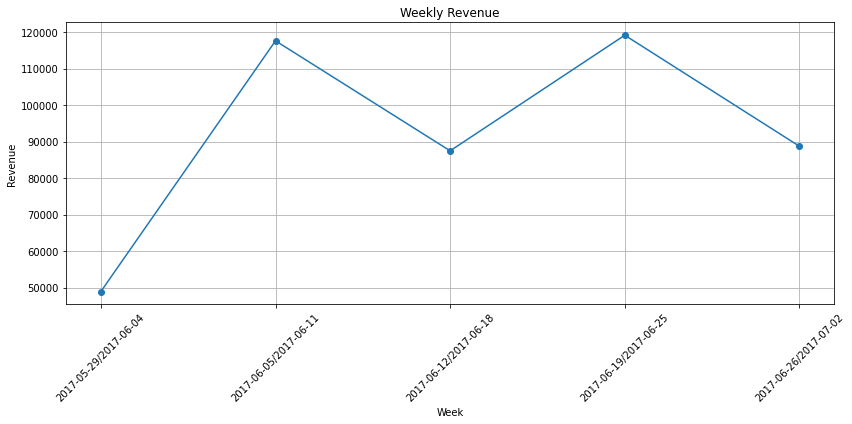

In [35]:
# Агрегируем данные по неделям
df_metrics_query_delivered['week'] = df_metrics_query_delivered['order_delivered_customer_date'].dt.to_period('W')
weekly_revenue = df_metrics_query_delivered.groupby('week')['revenue'].sum().reset_index()

# Преобразуем столбец с неделями в формат строки для отображения на графике
weekly_revenue['week'] = weekly_revenue['week'].astype(str)

# Строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(weekly_revenue['week'], weekly_revenue['revenue'], marker='o')
plt.title('Weekly Revenue')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Вторая метрика — показывает объем аудитории, которой продукт доставляет ценность.
Учитывая, что наш продукт - это маркетплейс, соответственно, ценность продукта проявляется в том, чтобы клиент возвращался в наш продукт делать новые заказы. 
Соответственно, метрикой может быть аудитория маркетплейса, которая делает повторные заказы.

Active Users = Количество уникальных пользователей с повторными заказами

In [36]:
# Считаем количество уникальных пользователей с повторными заказами
active_users = df_3.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
not_active_users = df_3.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
unique_active_users = active_users['customer_unique_id'].nunique()
not_unique_active_users = not_active_users['customer_unique_id'].nunique()


print(f"Объём пользователей, которые возвращаются в продукт: {unique_active_users}")
print(f"Объём пользователей, которые не возвращаются в продукт: {not_unique_active_users}")

Объём пользователей, которые возвращаются в продукт: 11869
Объём пользователей, которые не возвращаются в продукт: 83551


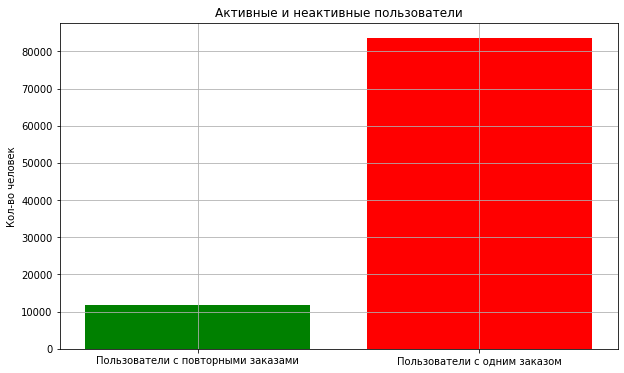

In [37]:
# Строим гистограмму
plt.figure(figsize=(10, 6))
plt.bar(['Пользователи с повторными заказами', 'Пользователи с одним заказом'], [unique_active_users, not_unique_active_users], color=['green', 'red'])
plt.title('Активные и неактивные пользователи')
plt.ylabel('Кол-во человек')
plt.grid(True)
plt.show()

Из графика становится понятно, что у продукта есть определенные проблемы с возвращением пользователей в продукт. 

Третья метрика должна показывать заинтересованность новых клиентов в продукте. 
Здесь может подойти Conversion Rate. В рамках нашего продукта, это может быть как отношение новых пользователей, которые совершили повторный заказ ко всем пользователям.

Conversion Rate = Кол-во пользователей с повторными заказами / Общее кол-во новых пользователей

In [38]:
# Фильтруем данные за июнь 2017 года (новые пользователи)
new_users_june = df_3[df_3['order_delivered_customer_date'].dt.month == 6]

# Находим пользователей с повторными заказами
repeat_users = new_users_june.groupby('customer_unique_id').filter(lambda x: len(x) > 1)

# Считаем количество новых пользователей и пользователей с повторными заказами
total_new_users = new_users_june['customer_unique_id'].nunique()
total_repeat_users = repeat_users['customer_unique_id'].nunique()

# Рассчитываем Conversion Rate
conversion_rate = total_repeat_users / total_new_users

# Выводим результат
print(f"Conversion Rate за июнь 2017 года: {conversion_rate:.4f}")

Conversion Rate за июнь 2017 года: 0.1135


Четвертная метрика - отражает вовлеченность клиента в продолжение использования продукта.
Одна из ключевых метрик - Retention Rate. Показывает, какая доля пользователей возвращается и продолжает использовать продукт после первого заказа. Это ключевой показатель удовлетворенности и вовлеченности пользователей.

Retention Rate = Кол-во пользователей, вернувшихся в следующий период / Кол-во пользователей в текущем периоде

In [39]:
# Разделяем пользователей на когорты
cohorts = df_3.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index(name='cohort_date')
cohorts['cohort_month'] = cohorts['cohort_date'].dt.to_period('M')

# Считаем retention
retention_data = df_3.merge(cohorts[['customer_unique_id', 'cohort_month']], on='customer_unique_id')
retention_data['order_month'] = retention_data['order_purchase_timestamp'].dt.to_period('M')
retention_data['retention'] = retention_data['order_month'] == retention_data['cohort_month']

# Считаем долю вернувшихся пользователей
retention_rate = retention_data.groupby('cohort_month')['retention'].mean()

print(f"Retention Rate: {retention_rate.mean():.4f}")

Retention Rate: 0.9547


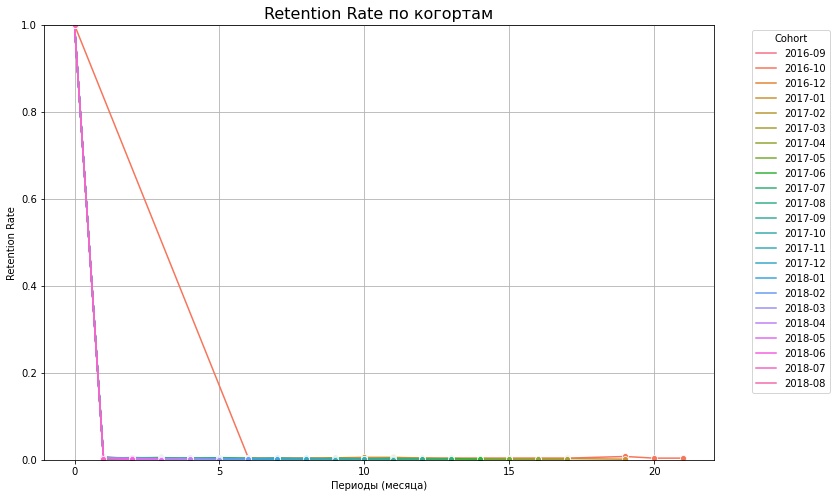

In [42]:
# Преобразуем матрицу retention в длинный формат для построения графика
retention_long = retention_matrix.reset_index().melt(id_vars='cohort', var_name='period_number_month', value_name='retention_rate')
plt.figure(figsize=(12, 8))
sns.lineplot(data=retention_long, x='period_number_month', y='retention_rate', hue='cohort', marker='o')
plt.title('Retention Rate по когортам', fontsize=16)
plt.xlabel('Периоды (месяца)')
plt.ylabel('Retention Rate')
plt.ylim(0, 1)
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Пятая метрика - отражает денежное выражение вовлеченности клиента.
На описание этой метрики подходит ARPU - показатель, сколько в среднем приносит один пользователь прибыли. 

ARPU = Общий доход / Кол-во уникальных пользователей.

In [44]:
# Добавляем столбец с месяцем и годом и столбец revenue для df_3
df_3['year_month'] = df_3['order_delivered_customer_date'].dt.to_period('M')
df_3['revenue'] = df_3['price'] * df_3['order_item_id']

# Агрегируем данные по месяцам
monthly_data = df_3.groupby('year_month').agg(
    total_revenue=('revenue', 'sum'),
    unique_users=('customer_unique_id', 'nunique')
).reset_index()

# Рассчитываем ARPU
monthly_data['ARPU'] = monthly_data['total_revenue'] / monthly_data['unique_users']

# Выводим результат
print(monthly_data[['year_month', 'ARPU']])

   year_month        ARPU
0     2016-10  166.271699
1     2016-11  202.425833
2     2016-12  189.715000
3     2017-01  141.853295
4     2017-02  169.990602
5     2017-03  157.627842
6     2017-04  160.924750
7     2017-05  154.364463
8     2017-06  150.052122
9     2017-07  147.509183
10    2017-08  142.444786
11    2017-09  170.977532
12    2017-10  181.359022
13    2017-11  161.260967
14    2017-12  153.409379
15    2018-01  145.191817
16    2018-02  145.071168
17    2018-03  155.543181
18    2018-04  159.936315
19    2018-05  163.897606
20    2018-06  168.137959
21    2018-07  154.432725
22    2018-08  154.640934
23    2018-09  206.691786
24    2018-10   91.800000


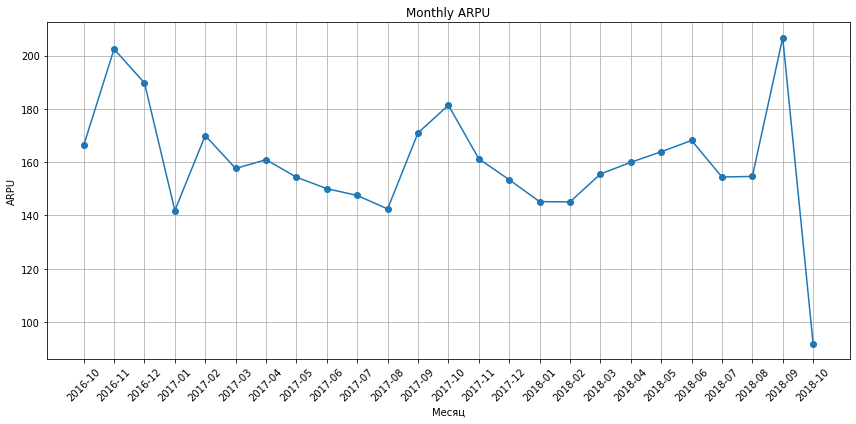

In [45]:
# Преобразуем столбец с месяцем и годом в формат строки для отображения на графике
monthly_data['year_month'] = monthly_data['year_month'].astype(str)

# Строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['year_month'], monthly_data['ARPU'], marker='o')
plt.title('Monthly ARPU')
plt.xlabel('Месяц')
plt.ylabel('ARPU')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Для расчёта Impact возьмите данные с июня 2017 года. Считайте, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта).

Гипотеза №1:

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

Значение метрики для всех 3 гипотез будет кол-во пользователей, которые пользуются продуктом.

In [53]:
# Фильтруем данные за июнь 2017 года и далее
users_june_and_more = df_3[df_3['order_delivered_customer_date'].dt.month >= 6]

In [55]:
# Выбироем те заказы, которые были отменены
users_june_and_more_query = users_june_and_more.query('order_status == "canceled"').

In [64]:
# Считаем уникальные значения для отмененных заказов и всех заказов, а после находим долю отмененных заказов
canceled_users = users_june_and_more_query['customer_unique_id'].nunique()
total_users = users_june_and_more['customer_unique_id'].nunique()

canceled_users_share = canceled_users / total_users
print(f"Доля отмененных заказов: {canceled_users_share:.4f}")

Доля отмененных заказов: 0.0001


Если исправить баг, то доля заказов, которые были отменены снизится до 0% и увеличится на 0,01%. Судя по шкале Impact, это будет 1, так как 0,01 = 1 пользователь. 

Гипотеза №2:
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. Считаем, что мы таким образом избавимся от всех отмен.

In [73]:
#Фильтруем столбцы, которые необходимы для поиска товаров с задержкой
late_orders = df_3[['customer_unique_id', 'order_status', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'deliver_date_difference_estimated', 'order_delivered_customer_date']]

In [81]:
#Выбираем только те значения в столбце deliver_date_difference_estimated, когда разница дней была отрицательной.
late_orders_share = late_orders[late_orders['deliver_date_difference_estimated'] < pd.Timedelta(0)]

In [83]:
# Считаем уникальные значения для заказов с опозданием и всех заказов, а после находим долю заказов с опозданием
late_orders_unique = late_orders_share['customer_unique_id'].nunique()
total_users = users_june_and_more['customer_unique_id'].nunique()
late_orders_share_ratio = late_orders_unique / total_users
print(f"Доля заказов с опозданием: {late_orders_share_ratio:.4f}")

Доля заказов с опозданием: 0.1514


Если сократим время до отгрузки заказа, то доля заказов с опозданием снизится до 0% и увеличится на 15,14%. Судя по шкале Impact, это будет 1, так как 15,14 = 15 пользователей.

Гипотеза №3:
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [87]:
# Фильтруем данные за июнь 2017 года и далее
june = df_3[df_3['order_delivered_customer_date'].dt.month >= 6]

# Находим пользователей с повторными заказами
repeat_users_june = june.groupby('customer_unique_id').filter(lambda x: len(x) > 1)

# Считаем количество новых пользователей и пользователей с повторными заказами
total_new_users_june = june['customer_unique_id'].nunique()
total_repeat_users_june = repeat_users_june['customer_unique_id'].nunique()

# Считаем общее кол-во пользователей без повторного заказа и умножаем на retention 1 месяца (из условия задачи):
all_june = (total_new_users_june - total_repeat_users_june) * 0.0035

print(f'Общее кол-во пользователей, которые совершат повторный заказ: {all_june}')

Общее кол-во пользователей, которые совершат повторный заказ: 158.361


Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то доля заказов увеличится. Учитывая, что мы умножали сразу на долю медианного 1 месяца retention, судя по шкале Impact, это будет 3, так как 158 пользователей. 

Рассчитываем фреймворк ICE по всем гипотезам: 

Гипотеза №1 = 1 * 8 * 6 = 48;
Гипотеза №2 = 1 * 10 * 4 = 40;
Гипотеза №3 = 3 * 5 * 9 = 135. 

По фреймворку, необходимо брать в работу третью гипотезу, но в основании первой гипотезы есть предложение по устранению бага. Учитывая, что устранение бага имеет первостепенный характер, необходимо обратить в первую очередь внимание на него. Далее на гипотезу №3 и гипотезу №2. 

Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

Для A/B теста я думаю можно использовать метрику APRU - Средний доход на одного платящего пользователя, ибо эту метрику можно посчитать. Она интерпретируемая: увеличив число платящих клиентов, мы сможем увидеть эффект в среднем доходе в сегменте платящих пользователей. Она чувствительна: среднее хорошо отражает изменения.

Сформулировать метрики, на которые должна повлиять выбранная вами гипотеза:

1. Revenue (Общий доход) = SUM (стоимость товара * кол-во товара)

Увеличение объема продаж будет прямым следствием увеличения количества доставленных заказов.

2. Кол-во доставленных заказов = SUM (customer_unique_id с фильтрацией 'delivered').

Метрика, которая показывает, что гипотеза работает — количество доставленных заказов должно увеличиться.

3. Active Users = Кол-во уникальных пользователей с повторными заказами. 

Увеличение количества активных пользователей, которые возвращаются и делают повторные заказы, будет свидетельствовать о том, что клиенты довольны продуктом.

4. Retention Rate = Кол-во пользователей с повторными заказами / Общее кол-во новых пользователей.

Увеличение Retention Rate будет показывать, что пользователи возвращаются и продолжают использовать продукт.

Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail:

1. Целевая метрика:

APRU = Общий доход / Кол-во уникальных пользователей.

Расчет этой метрики был представлен в 4 задании. Как и было описано выше, я считаю, это одна из целевых метрик в этой гипотезе. 

2. Прокси метрики: 

Conversion Rate = Кол-во пользователей с повторными заказами / Общее кол-во новых пользователей

Увеличение конверсии может указывать на то, что пользователи успешно завершают заказы, так как проблема отмены решена.

Среднее кол-во заказов в корзине = SUM (кол-во товаров в заказе) / кол-во заказов.

Косвенная метрика, так как это не всегда показатель, что увеличение корзины = покупка, тем не менее, увеличение среднего количества товаров в заказе может указывать на то, что пользователи доверяют продукту и делают более крупные заказы.

3. Guardrail метрики:

Количество отмененных отменненых заказов = SUM (customer_unique_id с фильтрацией 'canceled').
Эта метрика должна уменьшиться, так как гипотеза предполагает, что количество отмененных заказов сократится.

Задача 6. Теперь необходимо поделиться результатами проведённой работы с компанией.

1. Формализация проблемы продукта:
    
    У маркетплейса есть проблема с багом в процессинге оформления заказов, из-за чего происходят отмена заказов. 
    Помимо этого, есть проблема с тем, что товар приходит с опозданием, что может негативно повлиять на retention rate, так как люди не возвращаются после первой покупки.
    У маркетплейса низкие показатели возвращения клиентов в продукт, из-за чего низкий retention и отсутствует pmf.

2. Выводы по пункту 1:

Retention у продукта низкий, что говорит о том, что пользователи не задерживаются в продукте. Медианный retention первого месяца равен 0.0035, пятого месяца (сделанного по моей инициативе) = 0.0168, что говорит о снижении retention. Когорта с самым высоким retention на 3-й месяц - это январь 2017 года, там 0.56% возвращения пользователей. 

3. Выводы по пункту 2:

Product/market/fit в нашем продукте, маркетплейсе, отсутствует. Причин отсутствия PMF могут быть несколько:
Основные причины - проблемы с доставкой/отмененными заказами. К тому же, маленький процент тех, кто возвращается в маркетплейс опять - а значит, продукт не закрывает потребность клиента.

4. Выводы по пункту 3:

Основные метрики, которые были рассчитаны:

Объем продаж (Revenue) - в разрезе месяца (июня 2017 года) метрика показывает стабильный рост. 
Active Users - рассчитывалась на всех пользователей, которые делали повторный заказ и не делали его. Смотря на график, становится ясно, что только 12,44% пользователей делают повторный заказ. 
Conversion Rate - конверсия в повторные заказы - 0.1135, что опять же, говорит о проблеме возвращения пользователей в продукт.
Retention Rate - посчитанный Retention - 0.9547 (доля вернувшихся пользователей) плюс график, рассчитанный в 3 задании, показывает, что удержание пользователей все меньше и меньше. 
ARPU - средний доход, полученный с каждого пользователя показывал как увеличение, так и снижение на уровне всего продукта. 

5. Выводы по пункту 4:

По фреймворку, необходимо брать в работу третью гипотезу, но в основании первой гипотезы есть предложение по устранению бага. Учитывая, что устранение бага имеет первостепенный характер, необходимо обратить в первую очередь внимание на него. Далее на гипотезу №3 и гипотезу №2.

6. Выводы по пункту 5:

Метрики, на которых подействует выбранная гипотеза: 
- Объем продаж;
- Количество доставленных заказов;
- Active Users; 
- Retention Rate.

Целевая метрика:
- APRU.

Прокси метрики:

- Конверсия в совершении покупки;
- Среднее количество товаров в заказе.

Guardrail метрики:
- Количество отмененных заказов.

Эти метрики помогут вам оценить, насколько успешно работает наша гипотеза, и убедиться, что изменения не приводят к негативным последствиям.

7. Общие выводы по итогу исследования:

Продукт столкнулся с несколькими проблемами - низкий retention, доставка и отмененные заказы. Все эти процессы могут негативно повлиять на пользовательский опыт, что в целом и произошло - заинтересованность клиентов падает.
Были рассчитаны ключевые метрики, которые подсветили проблемы продукта и позволяющие сделать выводы о проблемных местах продукта.
Был произведен расчет фреймворк ICE и выбрана гипотеза, которая на мой взгляд, сможет устранить одну из ключевых проблем маркетплейса. 

8. Рекомендации по продукту:

На данный момент, с низким retention и следствие - отсутствием PMF, начинать масштабирование - плохая идея. Плохая в том плане, что может возникнуть эффект "дярявого ведра", так как проблемы с доставкой и отменой заказов не будут решены и люди не будут задерживаться в продукте. Соответственно, когда эти проблемы будут решены, тогда можно после анализа эффективности каналов, говорить о масштабировании продукта.

Как вариант, можно использовать такие каналы привлечения, как:

социальные сети;
SEO (система поиска);
обновить систему отзывов.

Стоит так же подумать о том, чтобы ввести рейтинг удовлетворенности пользователей, который поможет отслеживать ситуации, когда пользователь сталкивается с опытом, который стоит доработать. 

Пересмотреть и расширить поиск партнеров по доставке, чтобы снизить уровень заказов, доставленных с опозданием. В том числе, думать о том, как можно сократить время доставки до пользователя, возможно открыть новые точки в городах.